# Project : Student Performance Prediction 

## 1. Import all neccessary libraries


In [52]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold


## 2. Load dataset

In [3]:
df = pd.read_csv('/kaggle/input/student-performance-data/student_data.csv')
df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
# Get the shape of dataframe
df.shape


(395, 33)

## 3. Data Preprocessing

In [5]:
# Check for missing values
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [6]:
# get the statistics of each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

**'Get the distribution of "G3" (student performance) over the dataframe'**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


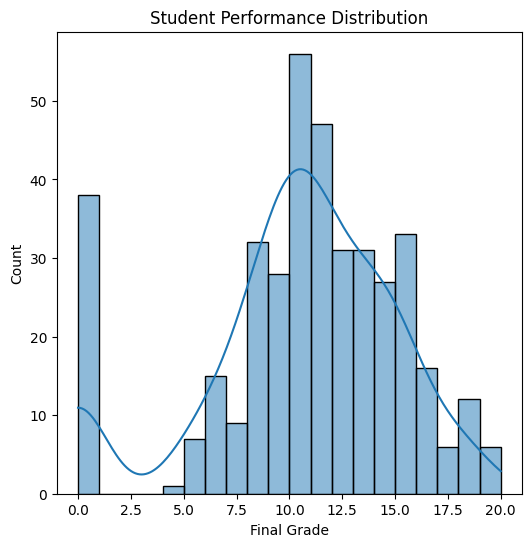

In [7]:
plt.figure(figsize = (6,6))
sns.histplot( data = df, x = 'G3', bins = 20, kde = True)
plt.title('Student Performance Distribution')
plt.xlabel('Final Grade')
plt.ylabel('Count')
plt.show()

In [8]:
# get all the categorical features from the dataset
categorical_features = [feature for feature in df.columns if df[feature].dtype == object]


In [9]:
for cat_feature in categorical_features:
    print(f'Unique Values in {cat_feature} are:')
    print(*df[cat_feature].unique(), sep=', ')
    print('\n')


Unique Values in school are:
GP, MS


Unique Values in sex are:
F, M


Unique Values in address are:
U, R


Unique Values in famsize are:
GT3, LE3


Unique Values in Pstatus are:
A, T


Unique Values in Mjob are:
at_home, health, other, services, teacher


Unique Values in Fjob are:
teacher, other, services, health, at_home


Unique Values in reason are:
course, other, home, reputation


Unique Values in guardian are:
mother, father, other


Unique Values in schoolsup are:
yes, no


Unique Values in famsup are:
no, yes


Unique Values in paid are:
no, yes


Unique Values in activities are:
no, yes


Unique Values in nursery are:
yes, no


Unique Values in higher are:
yes, no


Unique Values in internet are:
no, yes


Unique Values in romantic are:
no, yes




In [10]:
# Perfroming Label encoding on numerical features
for cat_feature in categorical_features:
    df[cat_feature] = pd.Categorical(df[cat_feature]).codes

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


## 4. Feature Selection / Dimensinality Reduction

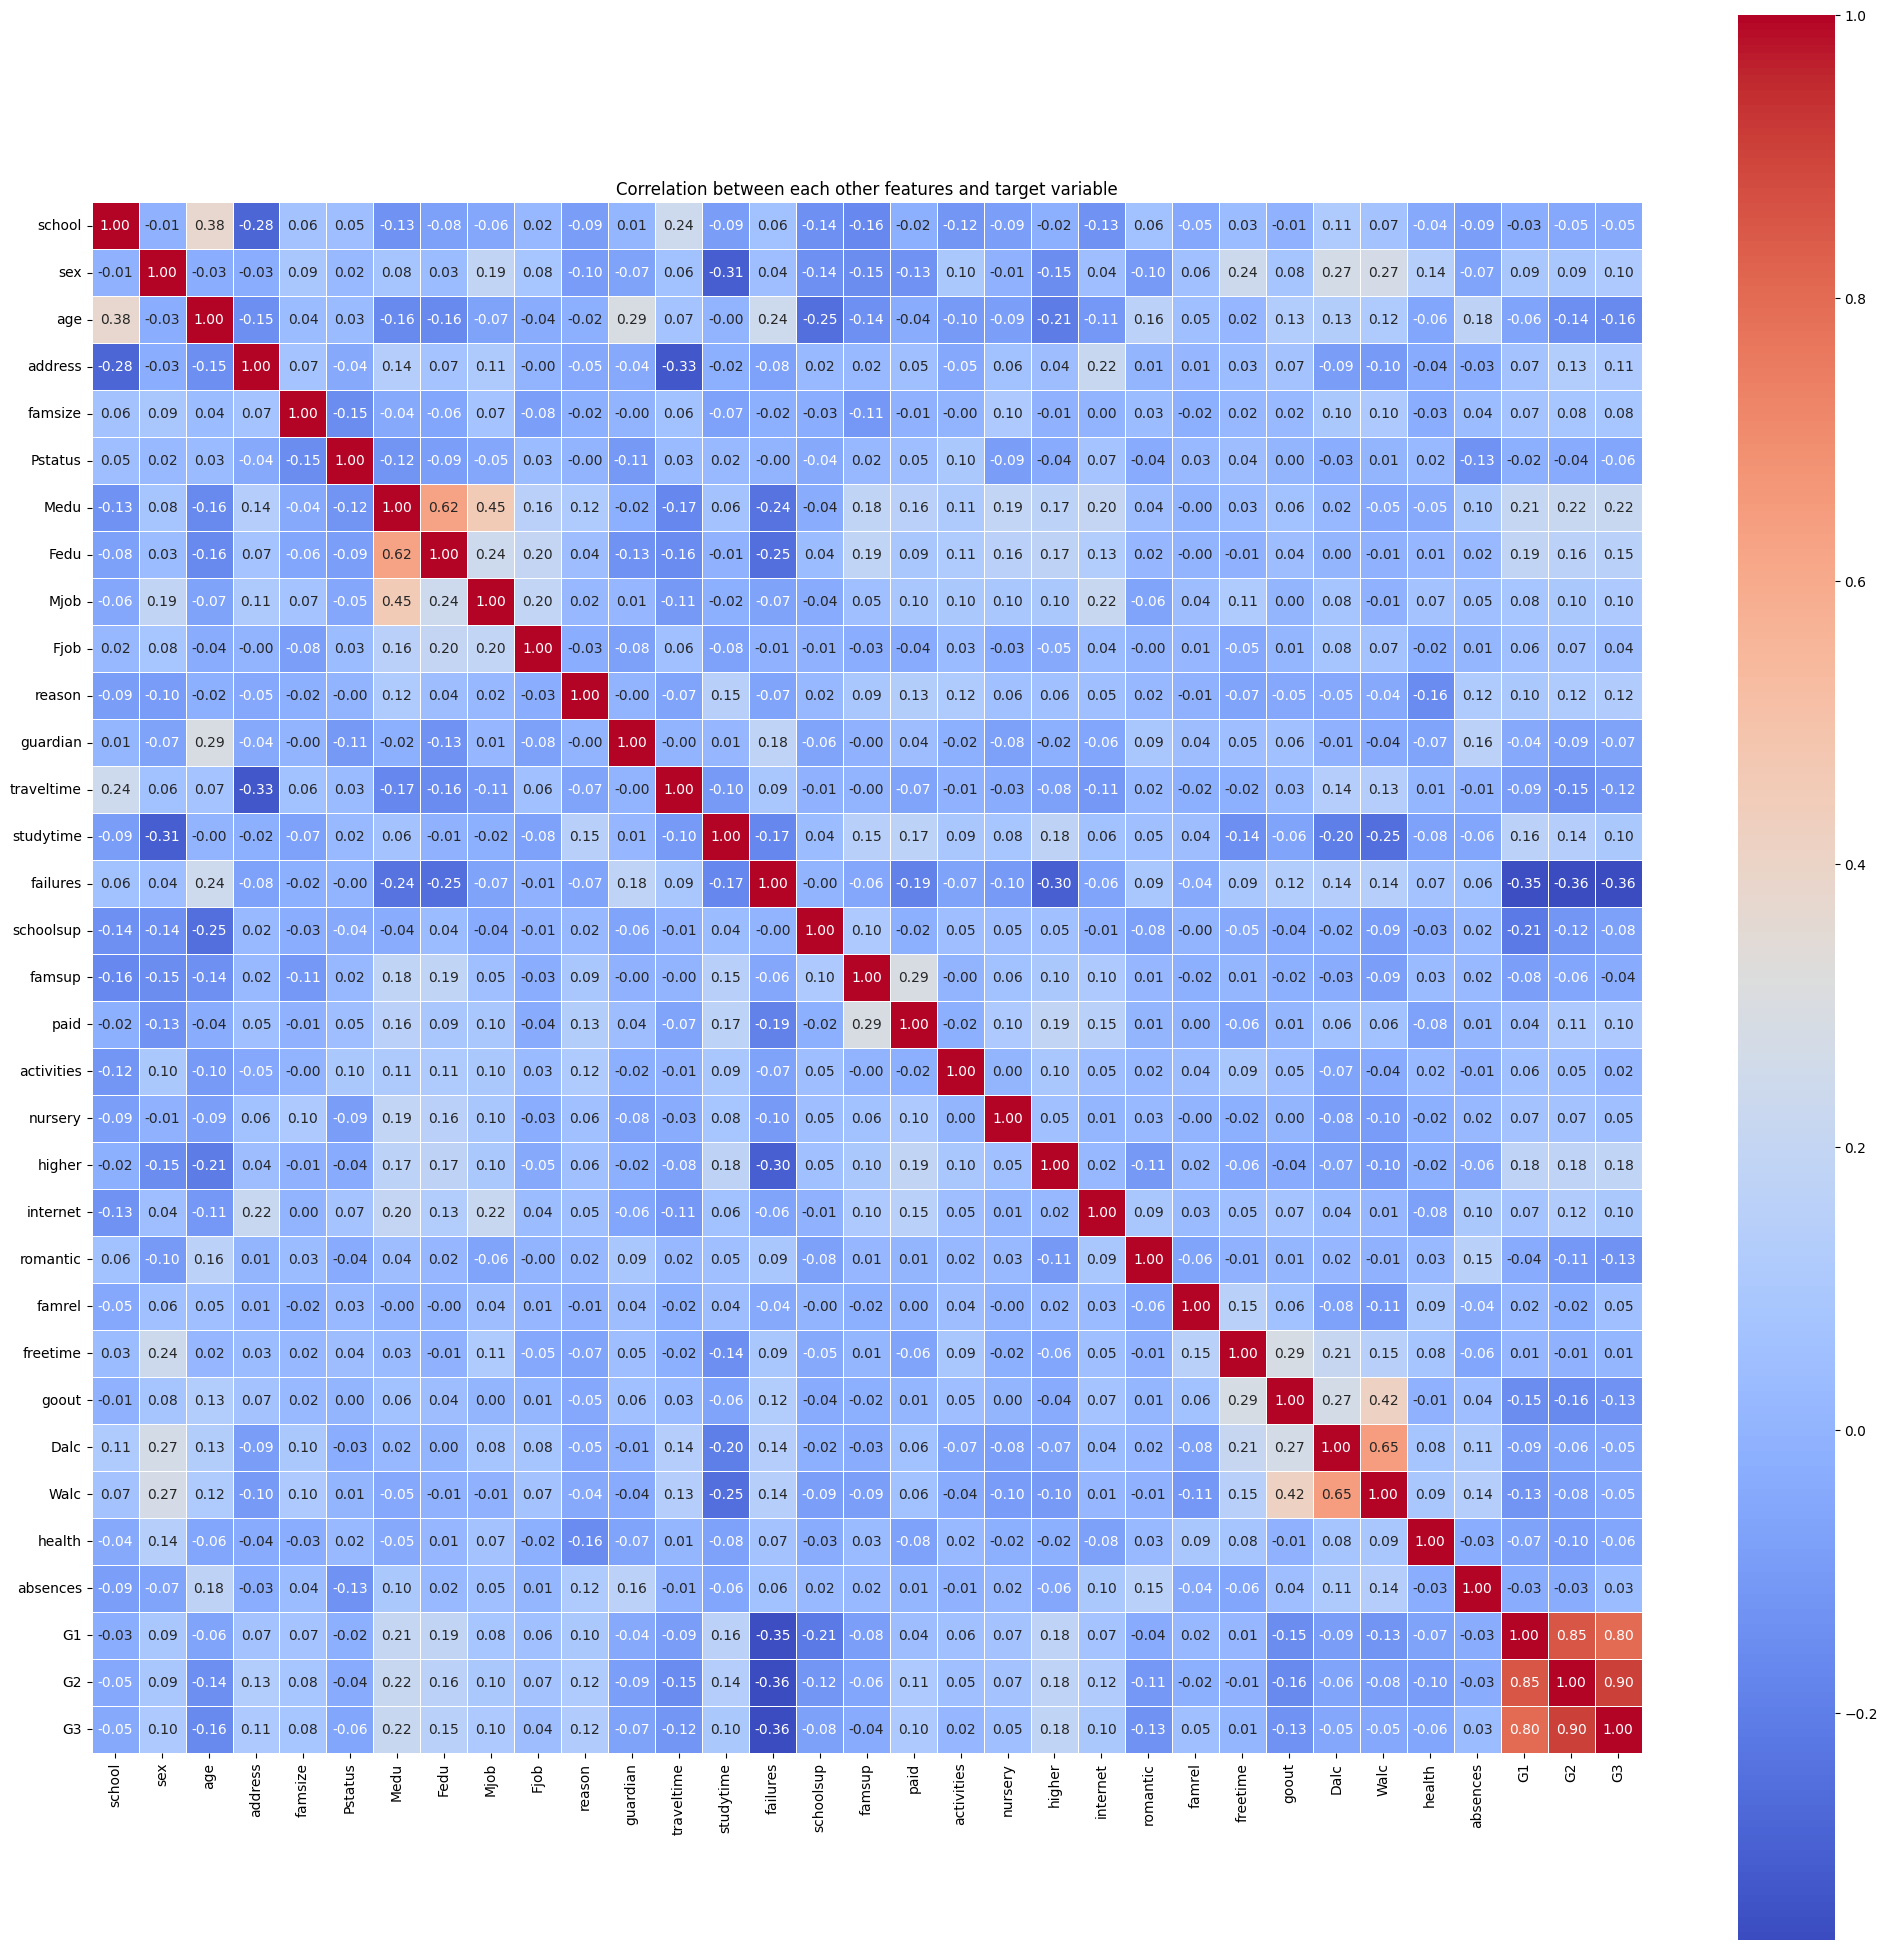

In [11]:
# getting correlation and statistics data
correlation_matrix = df.corr()

plt.figure(figsize=(25,25))
sns.heatmap(
    correlation_matrix,
    annot = True,
    cmap = 'coolwarm',
    fmt = '.2f',
    square = True,
    linewidth = '0.5'
)
plt.title('Correlation between each other features and target variable')
plt.show()


**Compute the threshold for getting most related feature among other, by calculating the average correlation value in 'G3**


failures      0.129899
Medu          0.047153
higher        0.033293
age           0.026108
Fedu          0.023243
goout         0.017634
romantic      0.016892
reason        0.014883
traveltime    0.013722
address       0.011184
sex           0.010703
Mjob          0.010421
paid          0.010403
internet      0.009699
studytime     0.009569
schoolsup     0.006854
famsize       0.006627
guardian      0.004915
health        0.003762
Pstatus       0.003365
Dalc          0.002988
Walc          0.002698
nursery       0.002659
famrel        0.002638
school        0.002027
Fjob          0.001788
famsup        0.001533
absences      0.001173
activities    0.000259
freetime      0.000128
Name: G3, dtype: float64


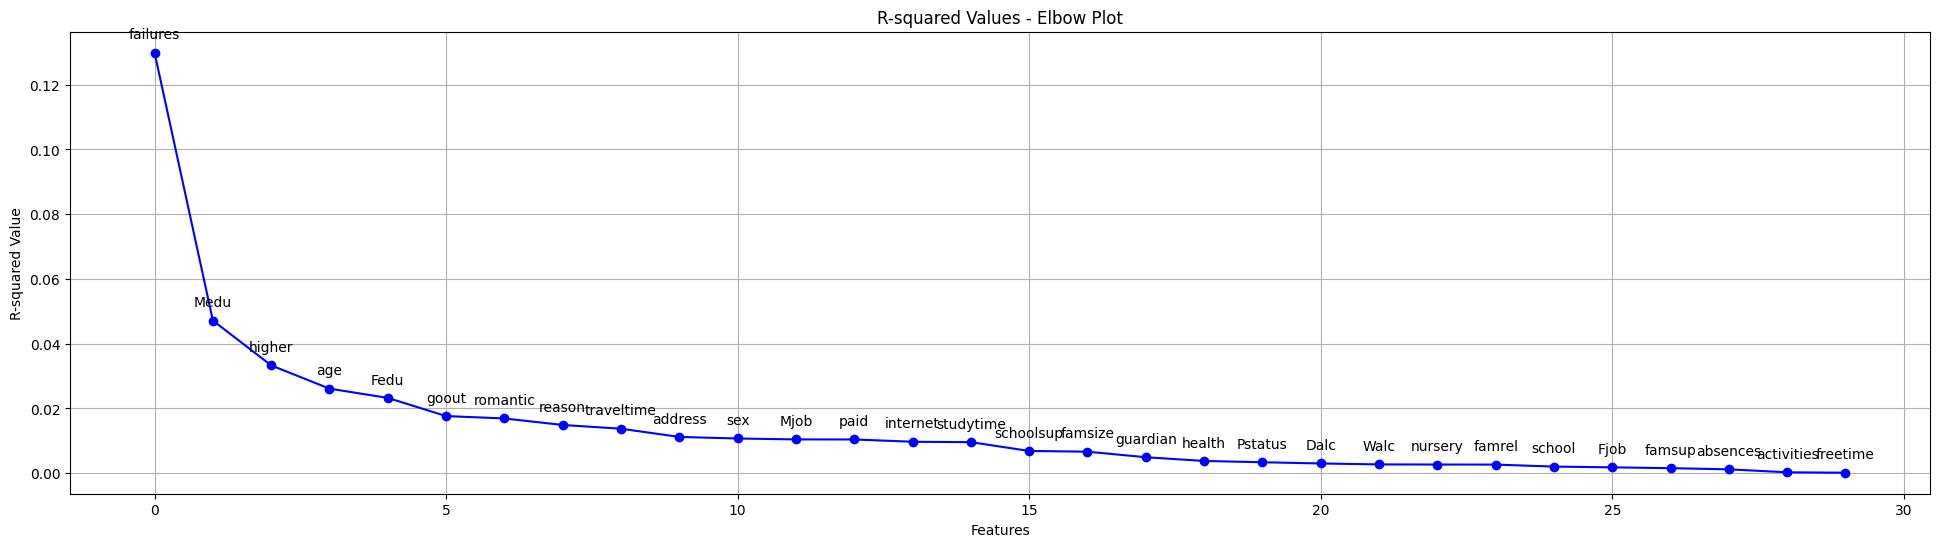

In [12]:
def get_r2_correlation(correlation_matrix, target_feature):
    '''
    Use R2 sqaure method to determine the threshold
    '''
    correlation = correlation_matrix[target_feature].drop(target_feature)
    return correlation ** 2

r_squared = get_r2_correlation(correlation_matrix, 'G3').sort_values(ascending = False)


# Sort R-squared values
sorted_r2 = r_squared.sort_values(ascending=False)

# Drop G1 and G2 as they are intermediate grades
sorted_r2 = sorted_r2.drop(['G1', 'G2'])
print(sorted_r2)

# Create elbow plot
plt.figure(figsize=(24, 6))
plt.plot(range(len(sorted_r2)), sorted_r2.values, 'bo-')
plt.title('R-squared Values - Elbow Plot')
plt.xlabel('Features')
plt.ylabel('R-squared Value')
plt.grid(True)

# Add feature names to points
for i, txt in enumerate(sorted_r2.index):
    plt.annotate(txt, (i, sorted_r2.iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [13]:
def get_threshold_using_std(r_squared_values):
    mean = r_squared_values.mean()
    std = r_squared_values.std()
    threshold = std - mean
    return threshold

# Calculate threshold
threshold = get_threshold_using_std(sorted_r2)
selected_features = (sorted_r2[sorted_r2 > threshold]).index.to_list()

print(f'Threshold :{threshold}')
print(f'Selected Features are : \n{selected_features}')

Threshold :0.010040818673373452
Selected Features are : 
['failures', 'Medu', 'higher', 'age', 'Fedu', 'goout', 'romantic', 'reason', 'traveltime', 'address', 'sex', 'Mjob', 'paid']


## 5. Data Preparation

In [14]:
# add feature 'G3', 'G2', 'G1'
additional_feature = ['G1', 'G2', 'G3']
selected_features.extend(additional_feature)
df = df[selected_features]
df.head()

,failures,Medu,higher,age,Fedu,goout,romantic,reason,traveltime,address,sex,Mjob,paid,G1,G2,G3
0,0,4,1,18,4,4,0,0,2,1,0,0,0,5,6,6
1,0,1,1,17,1,3,0,0,1,1,0,0,0,5,5,6
2,3,1,1,15,1,2,0,2,1,1,0,0,1,7,8,10
3,0,4,1,15,2,2,1,1,1,1,0,1,1,15,14,15
4,0,3,1,16,3,2,0,1,1,1,0,2,1,6,10,10


#### 5.1 Splitting the dataframe into feature-target 

In [15]:
y, X = df['G3'], df.drop(columns=['G3'])


#### 5.2 Splitting into training and testing dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(f' Shape of X_train : {X_train.shape} \n Shape of y_train : {y_train.shape} \n Shape of X_test : {X_test.shape} \n Shape of y_test : {y_test.shape}')

 Shape of X_train : (316, 15) 
 Shape of y_train : (316,) 
 Shape of X_test : (79, 15) 
 Shape of y_test : (79,)


In [70]:
X_test.head()

,failures,Medu,higher,age,Fedu,goout,romantic,reason,traveltime,address,sex,Mjob,paid,G1,G2
78,3,2,0,17,1,1,0,1,2,1,1,2,0,8,8
371,0,1,0,18,2,3,1,2,3,0,1,0,1,14,12
248,1,3,1,18,3,3,1,0,1,0,1,2,0,3,5
55,0,2,1,16,1,4,1,2,1,1,0,2,1,8,9
390,2,2,1,20,2,4,0,0,1,1,1,3,1,9,9


In [73]:
y_test.head()

78     10
371    12
248     5
55     10
390     9
Name: G3, dtype: int64

In [56]:
def compare_model(X_train, y_train, X_test, y_test, random_state = 42):
    model = {
        'Linear Regression' : LinearRegression(),
        'Lasso Regression' : Lasso(alpha=1.0),
        'Ridge Regression' : Ridge(alpha=1.0),
        'Random Forest Regressor' : RandomForestRegressor(n_estimators = 100, random_state = random_state),
        'XGBoost Regressor' : XGBRegressor(n_estimators = 100, random_state = random_state)
    }

    # scale the features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Cross Validation
    kf = KFold( n_splits = 5, shuffle = True, random_state = random_state)

    #result
    results = {}

    #training
    for name, model in model.items():
        # fit the model
        model.fit(X_train_scaled, y_train)

        # make the prediction on training and testing data
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # Evaluate result
        train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
        train_r2 = r2_score(y_train, y_train_pred)

        test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))
        test_r2 = r2_score(y_test, y_test_pred)

        # cross validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv = kf, scoring='r2')

        results[name] = {
            'train_rmse': round(train_rmse, 2),
            'test_rmse': round(test_rmse, 2),
            'train_r2': round(train_r2, 2),
            'test_r2': round(test_r2, 2),
            'cv_r2_mean': round(cv_scores.mean(), 2),
            'cv_r2_std': round(cv_scores.std(), 2),
            'model': model
        }

    return results, scaler

In [59]:
results, scaler = compare_model(X_train, y_train, X_test, y_test)

In [60]:
for model, metrics in results.items():
    print(f'Model : {model}')
    print(f'Metrics : {metrics}')

Model : Linear Regression
Metrics : {'train_rmse': 1.83, 'test_rmse': 2.21, 'train_r2': 0.84, 'test_r2': 0.76, 'cv_r2_mean': 0.82, 'cv_r2_std': 0.04, 'model': LinearRegression()}
Model : Lasso Regression
Metrics : {'train_rmse': 2.17, 'test_rmse': 2.23, 'train_r2': 0.78, 'test_r2': 0.76, 'cv_r2_mean': 0.77, 'cv_r2_std': 0.05, 'model': Lasso()}
Model : Ridge Regression
Metrics : {'train_rmse': 1.83, 'test_rmse': 2.21, 'train_r2': 0.84, 'test_r2': 0.76, 'cv_r2_mean': 0.82, 'cv_r2_std': 0.04, 'model': Ridge()}
Model : Random Forest Regressor
Metrics : {'train_rmse': 0.78, 'test_rmse': 2.32, 'train_r2': 0.97, 'test_r2': 0.74, 'cv_r2_mean': 0.82, 'cv_r2_std': 0.05, 'model': RandomForestRegressor(random_state=42)}
Model : XGBoost Regressor
Metrics : {'train_rmse': 0.01, 'test_rmse': 2.65, 'train_r2': 1.0, 'test_r2': 0.66, 'cv_r2_mean': 0.8, 'cv_r2_std': 0.08, 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
     

#### Conclusion:

Based on these results, I will go with Ridge Regression model. Here's why:

**Ridge Regression:**
    train_rmse: 1.83, test_rmse: 2.21
    train_r2: 0.84, test_r2: 0.76
    cv_r2_mean: 0.82, cv_r2_std: 0.04
    
    Shows good balance between training and test performance
    Small gap between train and test metrics indicates good generalization
    Low cross-validation standard deviation (0.04) suggests stable performance

**Why not the others:**

* Linear Regression:
      Has identical performance to Ridge, but Ridge is preferred as it handles multicollinearity better

* Random Forest:
    * Shows signs of overfitting:
        * Large gap between train_rmse (0.78) and test_rmse (2.32)
        * Very high train_r2 (0.97) vs test_r2 (0.74)

* XGBoost:
    * Clear overfitting:
        * Perfect training score (train_r2 = 1.0) but worse test performance (test_r2 = 0.66)
        * Largest gap between train_rmse (0.01) and test_rmse (2.65)
        * Highest cross-validation standard deviation (0.08) indicating less stable performance

* Lasso:
    * Slightly worse performance than Ridge
    * Lower train_r2 (0.78) and cv_r2_mean (0.77)

## 6. Make Prediction

In [84]:
def predict_with_ridge(results, X, scaler):
    """
    Predicts using the Ridge Regression model.

    Parameters:
        results (dict): Output from the `compare_model` function containing all models and their metrics.
        X (array-like): Data for which predictions are to be made.
        scaler (StandardScaler): The scaler used during model training.

    Returns:
        array: Predictions made by the Ridge Regression model.
    """
    # Extract the Ridge model from the results
    ridge_model = results['Ridge Regression']['model']
    
    # Scale the input data
    X_scaled = scaler.transform(X)
    
    # Make predictions
    predictions = ridge_model.predict(X_scaled)
    
    return math.ceil(predictions[0]) 


In [90]:
# # Use the same scaler as in the training process
scaler = StandardScaler()
scaler.fit(X_train)  # Fit the scaler on training data

StandardScaler()

In [104]:
new_data = X_test.iloc[3]  
# new_data = [1, 3, 1, 18, 3, 3, 1, 0, 1, 0, 1, 2, 0, 3, 5]

# Call the prediction function
ridge_predictions = predict_with_ridge(results, [new_data], scaler)

print(f"Prediction : {ridge_predictions}")

Prediction : 9


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
